In [1]:
!pip install tqdm


In [5]:
# preprocess_fracture_type.ipynb
import tqdm
import os, cv2, random
import albumentations as A
from tqdm import tqdm

SRC = r"../Datasets/combined_dataset"          # original
OUT = r"../Datasets/processed/Fracture_Type"  # processed output
os.makedirs(OUT, exist_ok=True)

valid_ext = [".jpg",".jpeg",".png",".bmp"]

# augmentation - heavier for multi-class
augmentor = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=20, p=0.6),
    A.RandomBrightnessContrast(p=0.4),
    A.ShiftScaleRotate(shift_limit=0.08, scale_limit=0.12, rotate_limit=15, p=0.5),
    A.GaussNoise(p=0.2),
])

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

# create output folders
classes = [d for d in os.listdir(SRC) if os.path.isdir(os.path.join(SRC,d))]
for c in classes:
    os.makedirs(os.path.join(OUT, c), exist_ok=True)

# process and augment
for c in classes:
    src_dir = os.path.join(SRC, c)
    out_dir = os.path.join(OUT, c)
    files = [f for f in os.listdir(src_dir) if os.path.splitext(f)[1].lower() in valid_ext]
    for f in tqdm(files, desc=f"Processing {c}"):
        p = os.path.join(src_dir, f)
        img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
        if img is None: continue
        img = cv2.resize(img, (224,224))
        img = clahe.apply(img)            # enhance contrast
        cv2.imwrite(os.path.join(out_dir, f), img)
    # optional: augment minority classes to reach target_count
# optional balancing: compute counts and augment classes with fewer images


ModuleNotFoundError: No module named 'tqdm'

In [3]:
import sys
print(sys.executable)


C:\Users\lenovo\anaconda3\envs\boneai\python.exe


In [6]:
import sys
print(sys.executable)

C:\Users\lenovo\anaconda3\envs\boneai\python.exe


In [4]:
import sys
print(sys.executable)

C:\Users\lenovo\anaconda3\envs\boneai\python.exe


In [6]:
import sys
!{sys.executable} -m pip install tqdm --upgrade


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [7]:
from tqdm import tqdm
print("✅ tqdm working fine!")


✅ tqdm working fine!


In [8]:
# preprocess_fracture_type.ipynb
import tqdm
import os, cv2, random
import albumentations as A
from tqdm import tqdm

SRC = r"../Datasets/combined_dataset"          # original
OUT = r"../Datasets/processed/Fracture_Type"  # processed output
os.makedirs(OUT, exist_ok=True)

valid_ext = [".jpg",".jpeg",".png",".bmp"]

# augmentation - heavier for multi-class
augmentor = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=20, p=0.6),
    A.RandomBrightnessContrast(p=0.4),
    A.ShiftScaleRotate(shift_limit=0.08, scale_limit=0.12, rotate_limit=15, p=0.5),
    A.GaussNoise(p=0.2),
])

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

# create output folders
classes = [d for d in os.listdir(SRC) if os.path.isdir(os.path.join(SRC,d))]
for c in classes:
    os.makedirs(os.path.join(OUT, c), exist_ok=True)

# process and augment
for c in classes:
    src_dir = os.path.join(SRC, c)
    out_dir = os.path.join(OUT, c)
    files = [f for f in os.listdir(src_dir) if os.path.splitext(f)[1].lower() in valid_ext]
    for f in tqdm(files, desc=f"Processing {c}"):
        p = os.path.join(src_dir, f)
        img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
        if img is None: continue
        img = cv2.resize(img, (224,224))
        img = clahe.apply(img)            # enhance contrast
        cv2.imwrite(os.path.join(out_dir, f), img)


C:\Users\lenovo\anaconda3\envs\boneai\lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
Processing test: 0it [00:00, ?it/s]
Processing train: 0it [00:00, ?it/s]


In [20]:


import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [1]:
train_dir = r"C:\Users\lenovo\Desktop\FractureNet+\Datasets\combined_dataset\train"
test_dir = r"C:\Users\lenovo\Desktop\FractureNet+\Datasets\combined_dataset\test"

# Data Augmentation for better generalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    color_mode='rgb',      # ✅ convert grayscale → RGB
    batch_size=32,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    color_mode='rgb',      # ✅ convert grayscale → RGB
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

print("Class indices:", train_data.class_indices)




NameError: name 'ImageDataGenerator' is not defined

In [22]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Add classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(train_data.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()



ValueError: Shape mismatch in layer #1 (named stem_conv)for weight stem_conv/kernel. Weight expects shape (3, 3, 1, 32). Received saved weight with shape (3, 3, 3, 32)

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = r"C:\Users\lenovo\Desktop\FractureNet+\Datasets\combined_dataset\train"
test_dir = r"C:\Users\lenovo\Desktop\FractureNet+\Datasets\combined_dataset\test"


# ------------------------------
# Step 1: Data Preprocessing
# ------------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    color_mode='grayscale',   # ✅ grayscale safe
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# ------------------------------
# Step 2: CNN Model
# ------------------------------
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,1)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')
])

# ------------------------------
# Step 3: Compile & Train
# ------------------------------
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=15,
    validation_data=test_generator
)

model.save("fracture_type_model.h5")


Found 1978 images belonging to 10 classes.
Found 280 images belonging to 10 classes.


C:\Users\lenovo\anaconda3\envs\boneai\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\lenovo\anaconda3\envs\boneai\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.1249 - loss: 7.5372 - val_accuracy: 0.1000 - val_loss: 34.9632
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.1365 - loss: 2.4735 - val_accuracy: 0.0857 - val_loss: 37.5761
Epoch 3/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.1390 - loss: 2.3467 - val_accuracy: 0.0857 - val_loss: 23.3959
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.1390 - loss: 2.3240 - val_accuracy: 0.0857 - val_loss: 9.5124
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.1385 - loss: 2.3204 - val_accuracy: 0.1286 - val_loss: 2.9487
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.1390 - loss: 2.4080 - val_accuracy: 0.0643 - val_loss: 5.2977
Epoch 7/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.1370 - loss: 2.2969 - val_accuracy: 0.1286 - val_loss: 6.8211
Epoch 8/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.1395 - loss: 2.2818 - val_accuracy: 0.1214 - val_

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# ------------------------------
# Step 1: Data Setup
# ------------------------------
train_dir = r"C:\Users\lenovo\Desktop\FractureNet+\Datasets\combined_dataset\train"
test_dir = r"C:\Users\lenovo\Desktop\FractureNet+\Datasets\combined_dataset\test"


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    color_mode='rgb',   # ✅ Convert grayscale → RGB
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# ------------------------------
# Step 2: Model Definition
# ------------------------------
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in base_model.layers:
    layer.trainable = False  # Freeze base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# ------------------------------
# Step 3: Compile
# ------------------------------
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ------------------------------
# Step 4: Train
# ------------------------------
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10
)

# ------------------------------
# Step 5: Save
# ------------------------------
model.save("fracture_type_classifier.keras")


Found 1978 images belonging to 10 classes.
Found 280 images belonging to 10 classes.


ValueError: Shape mismatch in layer #1 (named stem_conv)for weight stem_conv/kernel. Weight expects shape (3, 3, 1, 32). Received saved weight with shape (3, 3, 3, 32)

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# ------------------------------
# Step 1: Data Setup
# ------------------------------
train_dir = r"C:\Users\lenovo\Desktop\FractureNet+\Datasets\combined_dataset\train"
test_dir = r"C:\Users\lenovo\Desktop\FractureNet+\Datasets\combined_dataset\test"

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    color_mode='rgb',   # ✅ Convert grayscale → RGB
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# ------------------------------
# Step 2: Model Definition
# ------------------------------
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in base_model.layers:
    layer.trainable = False  # Freeze base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# ------------------------------
# Step 3: Compile
# ------------------------------
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ------------------------------
# Step 4: Train
# ------------------------------
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10
)

# ------------------------------
# Step 5: Save
# ------------------------------
model.save("fracture_type_classifier.keras")


Found 1978 images belonging to 10 classes.
Found 280 images belonging to 10 classes.


ValueError: Shape mismatch in layer #1 (named stem_conv)for weight stem_conv/kernel. Weight expects shape (3, 3, 1, 32). Received saved weight with shape (3, 3, 3, 32)

In [6]:
# ==========================================================
# Fracture Type Classification using EfficientNetB0
# High Accuracy Version (Snehal)
# ==========================================================

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ==========================================================
# Dataset Paths
# ==========================================================
train_dir = r"C:\Users\lenovo\Desktop\FractureNet+\Datasets\combined_dataset\train"
test_dir = r"C:\Users\lenovo\Desktop\FractureNet+\Datasets\combined_dataset\test"

# ==========================================================
# Image Data Generators
# ==========================================================
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

# ==========================================================
# Data Loading (Auto handle grayscale or RGB)
# ==========================================================
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',  # Force RGB input
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',  # Force RGB input
    shuffle=False
)

# ==========================================================
# Model Building (EfficientNetB0)
# ==========================================================
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# ==========================================================
# Compile Model
# ==========================================================
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ==========================================================
# Callbacks
# ==========================================================
checkpoint = ModelCheckpoint("best_fracture_model.keras", monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# ==========================================================
# Training
# ==========================================================
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=30,
    callbacks=[checkpoint, early_stop],
    verbose=1
)

# ==========================================================
# Evaluate Model
# ==========================================================
loss, acc = model.evaluate(test_generator, verbose=1)
print(f"\n✅ Test Accuracy: {acc*100:.2f}%")

# ==========================================================
# Classification Report
# ==========================================================
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print("\nClassification Report:\n")
print(classification_report(test_generator.classes, y_pred, target_names=list(test_generator.class_indices.keys())))

# ==========================================================
# Confusion Matrix
# ==========================================================
cm = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(test_generator.class_indices.keys()),
            yticklabels=list(test_generator.class_indices.keys()))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ==========================================================
# Training Curves
# ==========================================================
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss over Epochs")
plt.legend()
plt.show()

# ==========================================================
# Save Final Model
# ==========================================================
model.save("fracture_type_classifier.keras")
print("\n✅ Model saved as 'fracture_type_classifier.keras'")


Found 1978 images belonging to 10 classes.
Found 280 images belonging to 10 classes.


ValueError: Shape mismatch in layer #1 (named stem_conv)for weight stem_conv/kernel. Weight expects shape (3, 3, 1, 32). Received saved weight with shape (3, 3, 3, 32)

In [7]:
# ==========================================================
# Fracture Type Classification (EfficientNet + Grayscale Fix)
# ==========================================================

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------
# Dataset Paths
# ------------------------------
train_dir = r"C:\Users\lenovo\Desktop\FractureNet+\Datasets\combined_dataset\train"
test_dir = r"C:\Users\lenovo\Desktop\FractureNet+\Datasets\combined_dataset\test"

# ------------------------------
# Data Generators (Grayscale)
# ------------------------------
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    color_mode='grayscale',  # use grayscale images
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# ------------------------------
# Model (Add Conv Layer to convert 1→3 channels)
# ------------------------------
input_tensor = Input(shape=(224, 224, 1))
x = Conv2D(3, (3, 3), padding='same')(input_tensor)  # convert 1-channel → 3-channel
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=x)

# Freeze base
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=input_tensor, outputs=output)

# ------------------------------
# Compile
# ------------------------------
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ------------------------------
# Callbacks
# ------------------------------
checkpoint = ModelCheckpoint("best_fracture_model.keras", monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# ------------------------------
# Train
# ------------------------------
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=25,
    callbacks=[checkpoint, early_stop],
    verbose=1
)

# ------------------------------
# Evaluate
# ------------------------------
loss, acc = model.evaluate(test_generator)
print(f"\n✅ Test Accuracy: {acc*100:.2f}%")

# ------------------------------
# Predictions
# ------------------------------
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print("\nClassification Report:\n")
print(classification_report(test_generator.classes, y_pred, target_names=list(test_generator.class_indices.keys())))

# ------------------------------
# Confusion Matrix
# ------------------------------
cm = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(test_generator.class_indices.keys()),
            yticklabels=list(test_generator.class_indices.keys()))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Found 1978 images belonging to 10 classes.
Found 280 images belonging to 10 classes.


ValueError: Layer count mismatch when loading weights from file. Model expected 132 layers, found 131 saved layers.

Found 1978 images belonging to 10 classes.
Found 280 images belonging to 10 classes.


C:\Users\lenovo\anaconda3\envs\boneai\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\lenovo\anaconda3\envs\boneai\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.1306 - loss: 3.6855 
Epoch 1: val_accuracy improved from None to 0.09286, saving model to best_fracture_cnn.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 36s 546ms/step - accuracy: 0.1395 - loss: 3.2338 - val_accuracy: 0.0929 - val_loss: 3.1932
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.1562 - loss: 2.4543 
Epoch 2: val_accuracy improved from 0.09286 to 0.10000, saving model to best_fracture_cnn.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 38s 609ms/step - accuracy: 0.1567 - loss: 2.4099 - val_accuracy: 0.1000 - val_loss: 3.8378
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.1522 - loss: 2.3426 
Epoch 3: val_accuracy improved from 0.10000 to 0.10714, saving model to best_fracture_cnn.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 35s 560ms/step - accuracy: 0.1486 - loss: 2.3269 - val_accuracy: 0.1071 - val_loss: 4.6427
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.1901 - loss: 2.2940 
Epoch 4: val_

C:\Users\lenovo\anaconda3\envs\boneai\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\lenovo\anaconda3\envs\boneai\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\lenovo\anaconda3\envs\boneai\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result

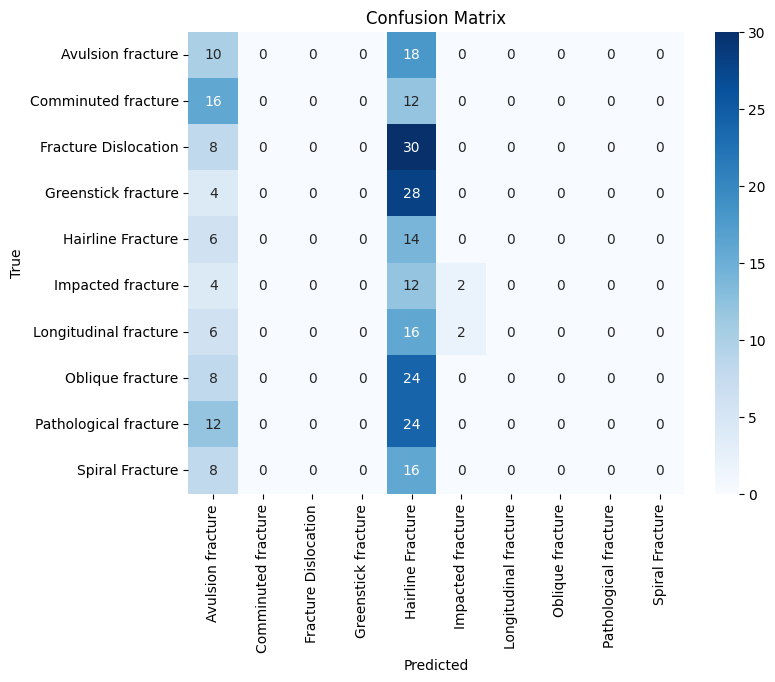

In [8]:
# ==========================================================
# Fracture Type Classification - Custom CNN (Grayscale)
# ==========================================================
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ------------------------------
# Dataset Paths
# ------------------------------
train_dir = r"C:\Users\lenovo\Desktop\FractureNet+\Datasets\combined_dataset\train"
test_dir = r"C:\Users\lenovo\Desktop\FractureNet+\Datasets\combined_dataset\test"

# ------------------------------
# Data Generators
# ------------------------------
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# ------------------------------
# CNN Model Definition
# ------------------------------
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,1)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

# ------------------------------
# Compile the model
# ------------------------------
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ------------------------------
# Callbacks
# ------------------------------
checkpoint = ModelCheckpoint("best_fracture_cnn.keras", monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# ------------------------------
# Train the model
# ------------------------------
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=20,
    callbacks=[checkpoint, early_stop],
    verbose=1
)

# ------------------------------
# Evaluate
# ------------------------------
loss, acc = model.evaluate(test_generator)
print(f"\n✅ Test Accuracy: {acc*100:.2f}%")

# ------------------------------
# Predictions
# ------------------------------
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

print("\nClassification Report:\n")
print(classification_report(test_generator.classes, y_pred, target_names=list(test_generator.class_indices.keys())))

# ------------------------------
# Confusion Matrix
# ------------------------------
cm = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(test_generator.class_indices.keys()),
            yticklabels=list(test_generator.class_indices.keys()))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Found 1978 images belonging to 10 classes.
Found 280 images belonging to 10 classes.
Class Weights: {0: np.float64(0.9073394495412844), 1: np.float64(0.7380597014925373), 2: np.float64(0.7218978102189781), 3: np.float64(0.9330188679245283), 4: np.float64(0.9792079207920792), 5: np.float64(1.3186666666666667), 6: np.float64(1.4544117647058823), 7: np.float64(1.4333333333333333), 8: np.float64(0.8525862068965517), 9: np.float64(1.3364864864864865)}


C:\Users\lenovo\anaconda3\envs\boneai\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
124/124 ━━━━━━━━━━━━━━━━━━━━ 99s 763ms/step - accuracy: 0.1021 - loss: 2.5566 - val_accuracy: 0.0786 - val_loss: 2.3164
Epoch 2/40
124/124 ━━━━━━━━━━━━━━━━━━━━ 95s 767ms/step - accuracy: 0.0915 - loss: 2.4881 - val_accuracy: 0.1071 - val_loss: 2.3125
Epoch 3/40
124/124 ━━━━━━━━━━━━━━━━━━━━ 106s 858ms/step - accuracy: 0.0971 - loss: 2.4178 - val_accuracy: 0.1286 - val_loss: 2.2967
Epoch 4/40
124/124 ━━━━━━━━━━━━━━━━━━━━ 101s 814ms/step - accuracy: 0.0976 - loss: 2.3994 - val_accuracy: 0.1143 - val_loss: 2.2971
Epoch 5/40
124/124 ━━━━━━━━━━━━━━━━━━━━ 104s 835ms/step - accuracy: 0.1203 - loss: 2.3581 - val_accuracy: 0.1357 - val_loss: 2.3123
Epoch 6/40
124/124 ━━━━━━━━━━━━━━━━━━━━ 106s 852ms/step - accuracy: 0.1062 - loss: 2.3515 - val_accuracy: 0.0714 - val_loss: 2.3203
Epoch 7/40
124/124 ━━━━━━━━━━━━━━━━━━━━ 97s 785ms/step - accuracy: 0.1148 - loss: 2.3530 - val_accuracy: 0.1286 - val_loss: 2.3146
Epoch 8/40
124/124 ━━━━━━━━━━━━━━━━━━━━ 99s 799ms/step - accuracy: 0.1001 - los

C:\Users\lenovo\anaconda3\envs\boneai\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\lenovo\anaconda3\envs\boneai\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\lenovo\anaconda3\envs\boneai\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result

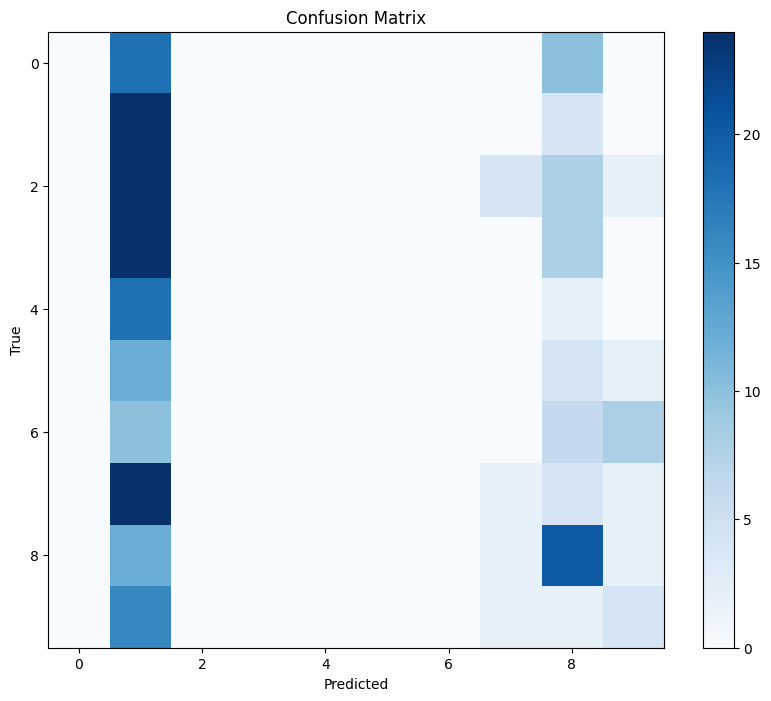

In [1]:
# ===============================
# FRACTURE TYPE CLASSIFIER (UPDATED)
# Using ResNet50 + Data Balancing
# ===============================

# Step 1: Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Step 2: Dataset Paths
train_dir = r"C:\Users\lenovo\Desktop\FractureNet+\Datasets\combined_dataset\train"
test_dir  = r"C:\Users\lenovo\Desktop\FractureNet+\Datasets\combined_dataset\test"

# Step 3: Image Preprocessing & Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=lambda x: np.stack((x,)*3, axis=-1) if x.shape[-1]==1 else x
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=lambda x: np.stack((x,)*3, axis=-1) if x.shape[-1]==1 else x
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

# Step 4: Class Weight Calculation (for Imbalance)
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

# Step 5: Model Definition (ResNet50)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in base_model.layers:
    layer.trainable = False  # Freeze base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Step 6: Compile
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Step 7: Callbacks
early_stop = EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_fracture_model.keras", monitor='val_accuracy', save_best_only=True)

# Step 8: Train
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=40,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint]
)

# Step 9: Evaluate
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")

# Step 10: Confusion Matrix & Classification Report
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

print("\nClassification Report:")
print(classification_report(test_generator.classes, y_pred, target_names=list(test_generator.class_indices.keys())))

cm = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(10,8))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
